# 1. Package

metric_fn -> default : nominal_metric

In [2]:
import simpledorff
import pandas as pd
import numpy as np

In [139]:
simpledorff.calculate_krippendorffs_alpha_for_df(sorting_data, experiment_col='img_id',
                                                 annotator_col='annotator_id',
                                                 class_col='annotation')

0.7530537374411139

### * github code

https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

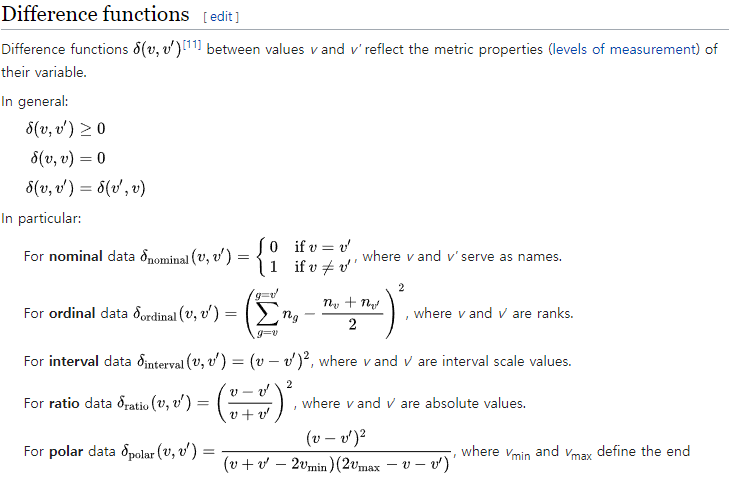

-> wikidocs 

In [96]:
def nominal_metric(a, b):
    return a != b

In [97]:
def interval_metric(a, b):
    return (a-b)**2

In [98]:
def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

# 2. 패키지 코드 뜯어보기

In [56]:
data = pd.read_excel('./krippendorff.xlsx')
data

,img,KIS,LYI,KJM,0,1,2,3
0,11,1,2,2,0,1,2,0
1,21,3,3,3,0,0,0,3
2,31,2,2,2,0,0,3,0
3,41,1,1,0,1,2,0,0
4,51,1,1,1,0,3,0,0
...,...,...,...,...,...,...,...,...
115,1166,0,0,0,3,0,0,0
116,1176,3,2,2,0,0,2,1
117,1186,2,2,2,0,0,3,0
118,1196,3,2,2,0,0,2,1


## 1. preprocess

krippendorff's alpha를 구하려면 다음과 같은 테이블 형식을 만족해야 함

예를 들어 단일 항목이 여러 사람에 의해 분류되는 경우, 

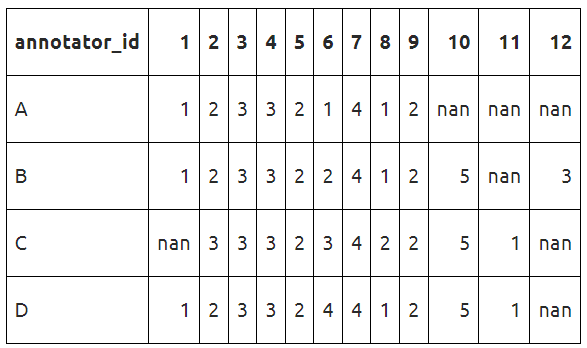

- 행은 annotator

- 열은 annotate되는 단위(단일 항목) - 우리는 이미지


In [91]:
def sorting(df, img_name_col, annotators_name):  # img_name_col : df에서 img_name이 있는 열 이름
    img_names = []
    annotators = []
    annotations = []
    sorting_data = pd.DataFrame()
    
    for i in range(len(df)):
        
        # img_id
        img_name = data[img_name_col][i]
        for j in range(len(annotators_name)):
            img_names.append(img_name)
        
        # annotator_id & annotations
        for name in annotators_name:
            annotators.append(name)
            annotations.append(df[name][i])
        
    sorting_data['img_id'] = img_names
    sorting_data['annotator_id'] = annotators
    sorting_data['annotation'] = annotations
    
    return sorting_data

In [92]:
sorting_data = sorting(data, 'img', ['KIS', 'LYI', 'KJM'])
sorting_data

,img_id,annotator_id,annotation
0,11,KIS,1
1,11,LYI,2
2,11,KJM,2
3,21,KIS,3
4,21,LYI,3
...,...,...,...
355,1196,LYI,2
356,1196,KJM,2
357,1206,KIS,3
358,1206,LYI,2


In [61]:
def df_to_experiment_annotator_table(df, experiment_col, annotator_col, class_col):
    return df.pivot_table(index=annotator_col, columns=experiment_col, values=class_col, aggfunc='first')

# pivot_table(피벗할 데이터프레임, 행 위치에 들어갈 열, 열 위치에 들어갈 열, 데이터로 사용할 열, 데이터 집계함수)
# aggfunc : default=mean인데, first를 사용하여 피봇하는 기준 테이블의 각 셀의 첫번째 값을 그냥 가져오게끔 해줌

In [99]:
df = df_to_experiment_annotator_table(sorting_data, 'img_id', 'annotator_id', 'annotation')
df

img_id,11,21,31,41,51,61,71,81,91,101,...,1116,1126,1136,1146,1156,1166,1176,1186,1196,1206
annotator_id,,,,,,,,,,,,,,,,,,,,,
KIS,1,3,2,1,1,3,3,1,0,0,...,2,0,1,2,1,0,3,2,3,3
KJM,2,3,2,0,1,2,3,1,0,0,...,2,0,1,2,1,0,2,2,2,3
LYI,2,3,2,1,1,2,3,1,0,0,...,2,0,1,2,1,0,2,2,2,2


## 2. Calculate

Krippendorff wants to calculate two quantities from this table
1. the observed number of disagreements (Do) and 
2. an Estimate of the likelihood of a disagreement occurring by chance (De)

-> Notice that the calculation happens "in the negative"... 'disagreements'

### Take your input table of experiments and transforms it into a new table

columns = experimnents = images..

lows = class..

the value of cell = the num of annotations 

**링크에서는 cell에 nan값이 있는 경우도 고려하여 계산하지만, 우리는 그런 경우 없으니 제외

In [70]:
# 엑셀에서 count 하는게 더 빠르니까.. (패키지 내부에 counter()함수 있으나 여기서 구현하기 귀찮으니까..)

vbu_df = pd.read_excel('./krippendorff.xlsx')
vbu_df = vbu_df.drop(['KIS', 'LYI', 'KJM'], axis=1)

vbu_df = vbu_df.T
vbu_df.columns = vbu_df.loc['img', :]
vbu_df.drop(['img'], inplace=True)
vbu_df

img,11,21,31,41,51,61,71,81,91,101,...,1116,1126,1136,1146,1156,1166,1176,1186,1196,1206
0,0,0,0,1,0,0,0,0,3,3,...,0,3,0,0,0,3,0,0,0,0
1,1,0,0,2,3,0,0,3,0,0,...,0,0,3,0,3,0,0,0,0,0
2,2,0,3,0,0,2,0,0,0,0,...,3,0,0,3,0,0,2,3,2,1
3,0,3,0,0,0,1,3,0,0,0,...,0,0,0,0,0,0,1,0,1,2


- Disagreement in a particular unit(experiment) is any column that has more than one value.
- In a particular unit(experiment), if we multiply two non-zero values the result is the total number of disagreements for that pair.
- If we take the 'sum of the products' in a column and divide it by '1 minus the sum of the entire column', we get the disagreement rate for that unit (experiment).  = (Do)..?
- Summing that across all columns gives us the observed disagreement rate.
- If column has only one response, and so it has no agreement information. We'll need to handle that case.

#### 2-1. frequency_dicts

In [83]:
def calculate_frequency_dicts(vbu_df):     # vbu : value by unit
    ubv_df = vbu_df.T                      
    vbu_df_masked = ubv_df.mask(ubv_df.sum(1) == 1, other=0).T   # 응답이 1인 것 삭제하는 코드 (우린 응답 안된거 없으니까 상관 ㄴㄴ)
    return dict(
        unit_freqs=vbu_df_masked.sum().to_dict(),
        class_freqs=vbu_df_masked.sum(1).to_dict(),
        total=vbu_df_masked.sum().sum()
        )

In [79]:
vbu_df_masked.sum().to_dict()

{11: 3,
 21: 3,
 31: 3,
 41: 3,
 51: 3,
 61: 3,
 71: 3,
 81: 3,
 91: 3,
 101: 3,
 111: 3,
 121: 3,
 131: 3,
 141: 3,
 151: 3,
 161: 3,
 171: 3,
 181: 3,
 191: 3,
 201: 3,
 212: 3,
 222: 3,
 232: 3,
 242: 3,
 252: 3,
 262: 3,
 272: 3,
 282: 3,
 292: 3,
 302: 3,
 312: 3,
 322: 3,
 332: 3,
 342: 3,
 352: 3,
 362: 3,
 372: 3,
 382: 3,
 392: 3,
 402: 3,
 413: 3,
 423: 3,
 433: 3,
 443: 3,
 453: 3,
 463: 3,
 473: 3,
 483: 3,
 493: 3,
 503: 3,
 513: 3,
 523: 3,
 533: 3,
 543: 3,
 553: 3,
 563: 3,
 573: 3,
 583: 3,
 593: 3,
 603: 3,
 614: 3,
 624: 3,
 634: 3,
 644: 3,
 654: 3,
 664: 3,
 674: 3,
 684: 3,
 694: 3,
 704: 3,
 714: 3,
 724: 3,
 734: 3,
 744: 3,
 754: 3,
 764: 3,
 774: 3,
 784: 3,
 794: 3,
 804: 3,
 815: 3,
 825: 3,
 835: 3,
 845: 3,
 855: 3,
 865: 3,
 875: 3,
 885: 3,
 895: 3,
 905: 3,
 915: 3,
 925: 3,
 935: 3,
 945: 3,
 955: 3,
 965: 3,
 975: 3,
 985: 3,
 995: 3,
 1005: 3,
 1016: 3,
 1026: 3,
 1036: 3,
 1046: 3,
 1056: 3,
 1066: 3,
 1076: 3,
 1086: 3,
 1096: 3,
 1106: 3,
 1116: 3

In [74]:
ubv_df.sum(1) 

img
11      3
21      3
31      3
41      3
51      3
       ..
1166    3
1176    3
1186    3
1196    3
1206    3
Length: 120, dtype: int64

In [81]:
vbu_df_masked.sum(1).to_dict()

{0: 91, 1: 89, 2: 115, 3: 65}

In [82]:
vbu_df_masked.sum().sum()

360

In [85]:
frequency_dicts = calculate_frequency_dicts(vbu_df)
frequency_dicts

{'unit_freqs': {11: 3,
  21: 3,
  31: 3,
  41: 3,
  51: 3,
  61: 3,
  71: 3,
  81: 3,
  91: 3,
  101: 3,
  111: 3,
  121: 3,
  131: 3,
  141: 3,
  151: 3,
  161: 3,
  171: 3,
  181: 3,
  191: 3,
  201: 3,
  212: 3,
  222: 3,
  232: 3,
  242: 3,
  252: 3,
  262: 3,
  272: 3,
  282: 3,
  292: 3,
  302: 3,
  312: 3,
  322: 3,
  332: 3,
  342: 3,
  352: 3,
  362: 3,
  372: 3,
  382: 3,
  392: 3,
  402: 3,
  413: 3,
  423: 3,
  433: 3,
  443: 3,
  453: 3,
  463: 3,
  473: 3,
  483: 3,
  493: 3,
  503: 3,
  513: 3,
  523: 3,
  533: 3,
  543: 3,
  553: 3,
  563: 3,
  573: 3,
  583: 3,
  593: 3,
  603: 3,
  614: 3,
  624: 3,
  634: 3,
  644: 3,
  654: 3,
  664: 3,
  674: 3,
  684: 3,
  694: 3,
  704: 3,
  714: 3,
  724: 3,
  734: 3,
  744: 3,
  754: 3,
  764: 3,
  774: 3,
  784: 3,
  794: 3,
  804: 3,
  815: 3,
  825: 3,
  835: 3,
  845: 3,
  855: 3,
  865: 3,
  875: 3,
  885: 3,
  895: 3,
  905: 3,
  915: 3,
  925: 3,
  935: 3,
  945: 3,
  955: 3,
  965: 3,
  975: 3,
  985: 3,
  995: 3,
  100

#### 2-2. calculate alpha

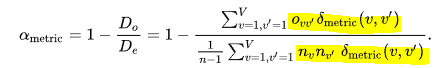

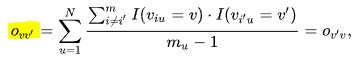

In [87]:
def calculate_de(frequency_dicts, metric_fn):       # param metric_fn metric function such as nominal_metric
    De = 0
    class_freqs = frequency_dicts["class_freqs"]
    class_names = list(class_freqs.keys())
    for i, cls in enumerate(class_names):
        for k in class_names:
            print('k :', k)
            print(class_freqs[cls])
            print(class_freqs[k])                   
            print(metric_fn(cls, k))                # cls = 0 고정되면서 k = 0,1,2,3 바뀜
            De += class_freqs[cls] * class_freqs[k] * metric_fn(cls, k)  # norminal_metric : cls!=k이면 true (0반환) => 즉, 같은 클래스끼린 계산 안함
    return De

In [118]:
vbu_df[11]

0    0
1    1
2    2
3    0
Name: 11, dtype: int64

In [121]:
unit_freqs = frequency_dicts['unit_freqs']
unit_freqs[11]

3

In [128]:
def calculate_do(vbu_table_dict, frequency_dicts, metric_fn):
    Do = 0
    unit_freqs = frequency_dicts['unit_freqs']
    unit_ids = list(unit_freqs.keys())
    for unit_id in unit_ids:    # unit_id = img 하나씩..
        unit_classes = list(vbu_table_dict[unit_id].keys())   # unit_classes = annotations [0,1,2,3]
        if unit_freqs[unit_id] < 2:    # 응답자가 2명 아래인 것 pass
            pass
        else:
            weight = 1 / (unit_freqs[unit_id] - 1)        # (unit_freqs[unit_id] - 1) : coincidence_matrics 에서 Mv-1
            for i, cls in enumerate(unit_classes):
                for k in unit_classes:
                    Do += (                               # De에서는 freqs(각 cls 개수)를 곱했고, Do에서는 
                        vbu_table_dict[unit_id][cls]      # 각 이미지의 클래스 별 count한 수 
                        * vbu_table_dict[unit_id][k]
                        * weight                          # 여기까지가 Ovv' = coincidence matrices
                        * metric_fn(cls, k)
                    )  
    return Do

In [135]:
def calculate_krippendorffs_alpha(vbu_table_dict, metric_fn=nominal_metric):
    #vbu_table_dict = data_transforms.make_value_by_unit_table_dict(ea_table_df)
    
    frequency_dict = calculate_frequency_dicts(vbu_table_dict)
    observed_disagreement = calculate_do(vbu_table_dict, frequency_dict, metric_fn)
    expected_disagreement = calculate_de(frequency_dict, metric_fn)
    N = frequency_dict['total']    # 360 (unit=120개씩 annotator 3명)
    
    alpha = 1 - (observed_disagreement / expected_disagreement)*(N-1)
    
    return alpha

In [140]:
alpha = calculate_krippendorffs_alpha(vbu_table_dict = vbu_df, metric_fn=nominal_metric)
alpha

k : 0
91
91
False
k : 1
91
89
True
k : 2
91
115
True
k : 3
91
65
True
k : 0
89
91
True
k : 1
89
89
False
k : 2
89
115
True
k : 3
89
65
True
k : 0
115
91
True
k : 1
115
89
True
k : 2
115
115
False
k : 3
115
65
True
k : 0
65
91
True
k : 1
65
89
True
k : 2
65
115
True
k : 3
65
65
False


0.7530537374411139